In [1]:
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [2]:
import numpy as np
import pandas as pd
import pydicom
import copy
%matplotlib inline
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from utility import *

In [3]:
from keras.models import model_from_json
from skimage.transform import resize
import matplotlib.image as image
from skimage import color
import glob, os

Using TensorFlow backend.


In [17]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename, verbose=False): 
    if verbose:
        print(f'Loading file: {filename} ...')
    
    dcm = pydicom.dcmread(filename)    

    if verbose:
        print(dcm)
        print(f'ID: {dcm.PatientID}')
        print(f'Sex: {dcm.PatientSex}')
        print(f'Age: {dcm.PatientAge}')
        print(f'Modality: {dcm.Modality}')
        print(f'Study Description: {dcm.StudyDescription}')
        print(f'Rows: {dcm.Rows}')
        print(f'Columns: {dcm.Columns}')
    
    # Age
    age = int(dcm.PatientAge)
    if age < 2 or age > 90:
        print(f'Image {filename} rejected, Age: {age}')
        return None

    # Body Part
    body_part = dcm.BodyPartExamined
    if body_part not in ['CHEST', 'chest']:
        print(f'Image {filename} rejected, Body part: {body_part}')
        return None
    
    # Patient Position
    pos = dcm.PatientPosition
    if pos not in ['PA', 'AP']:
        print(f'Image {filename} rejected, Patient position: {pos}')
        return None
    
    # Modali
    mod = dcm.Modality                            
    if mod != 'DX':
        print(f'Image {filename} rejected, Modality: {mod}')
        return None
    
#     print('Load file {} ...'.format(filename))
#     ds = pydicom.dcmread(filename)       
    img = dcm.pixel_array
    return img
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size, verbose=False): 
    if verbose:
        print(f'Image data: {img.shape}')
    
    if len(img.shape) == 3:
        img = color.rgb2gray(img)
#     print("after gray scale: ",np.max(img), np.min(img))    
    resized_img = resize(img, (img_size[1], img_size[2]), anti_aliasing=False)
    
    if verbose:
        print(f'Resized data: {resized_img.shape}')
#     print("after resize: ",np.max(resized_img), np.min(resized_img))
    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    
    if verbose:
        print(f'Processed data: {proc_img.shape}')

    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    with open(model_path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
   
    # load weights into new model
    model.load_weights(weight_path)
    print(f"Model loaded: {model}")

    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred = model.predict(img)
    prediction = pred > thresh
    # batch size: 1, single output
    return prediction 

In [18]:
! ls ./weights -lt
print()
data_dir = "./weights"
extension = 'hdf5'
image_files = glob.glob(os.path.join(data_dir, '*.{}'.format(extension)))

for i, file in enumerate(image_files):
    print(i,"  ", image_files[i])

total 321224
-rw-r--r-- 1 root root 164294880 Oct 25 10:37 xray_classification_model.best202010251022.hdf5
-rw-r--r-- 1 root root 164294880 Oct 11 04:55 xray_classification_model.best202010110429.hdf5

0    ./weights/xray_classification_model.best202010251022.hdf5
1    ./weights/xray_classification_model.best202010110429.hdf5


In [19]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "xray_classification_model.json"
weight_path = image_files[0]

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16

# Mean & std passed from outside not used
# Resize function used in preprocessing normalizes the image data automatically 
img_mean = -1           
img_std = -1

my_model = load_model(model_path, weight_path)
thresh = 0.356

Model loaded: <keras.engine.sequential.Sequential object at 0x7f60ea5bfa10>


In [20]:
def predict_dicom(filename):
    
    img = np.array([])
    img = check_dicom(filename)

    if img is None:
        return None
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    return pred[0][0]

Image test4.dcm rejected, Body part: RIBCAGE
Image test5.dcm rejected, Modality: CT
Image test6.dcm rejected, Patient position: XX


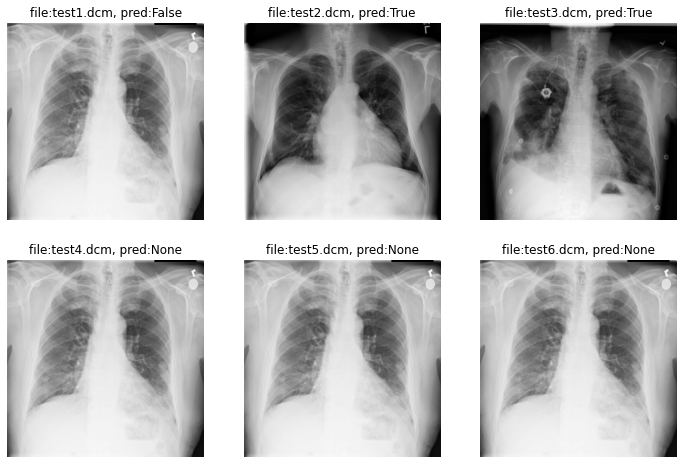

In [21]:
fig, axs = plt.subplots(2, 3, figsize = (12,8))
i = 0
for (file, ax) in zip(test_dicoms, axs.flatten()):
    img = pydicom.dcmread(file).pixel_array
    pred = predict_dicom(file)
    ax.imshow(img, cmap = 'gray')
    ax.set_title(f'file:{file}, pred:{pred}')
    ax.axis('off')
    i=i+1

In [22]:
def predict_image_prob(model, img): 
    return model.predict(img)[0][0]

def predict_valid(row):
    path = row['path']
    img_data = image.imread(path)
    img_prep = preprocess_image(img_data, -1, -1, IMG_SIZE, verbose=False)
    result = predict_image_prob(my_model, img_prep)

    return result

In [23]:
valid = pd.read_csv('pneumonia_valid.csv')
valid_df = copy.copy(valid)

In [24]:
valid_df['Pneumonia_pred'] = np.zeros(len(valid_df))
valid_df['Pneumonia_pred'] = valid_df.apply(lambda x: predict_valid(x), axis=1)
valid_df.to_csv('pneumonia_valid_pred.csv', index=False)

In [25]:
# valid_df = pd.read_csv('pneumonia_valid_pred.csv')
# print(valid_df.shape)

In [26]:
findings = set()
for f in valid_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses: {len(findings)}')
print(findings)
findings -= {'Pneumonia','No Finding'}

Total number of single diagnoses: 15
{'Emphysema', 'Atelectasis', 'Nodule', 'Hernia', 'Consolidation', 'Pleural_Thickening', 'No Finding', 'Cardiomegaly', 'Edema', 'Pneumonia', 'Mass', 'Fibrosis', 'Effusion', 'Pneumothorax', 'Infiltration'}


In [27]:
t = PrettyTable(['absent','auc','f1','thresh','precision','recall'])

valid_df2 = copy.copy(valid_df)
y = valid_df2['Pneumonia']
y_pred = valid_df2['Pneumonia_pred']
fpr, tpr, precision, recall, thresholds, auc = classification_metrics(y, y_pred)
f1scores, ind = f1_max(precision, recall, thresholds)

print("Classification metrics around (+/-)0.1 of the threshold value \
corresponding to max f1 score:\n")

th_opt_range = threshold_range(thresholds, ind)
for th in th_opt_range:
    idx = get_index(th, thresholds)
    print("f1: {:.3f}, threshold: {:.3f}, precision: {:.3f}, Recall: {:.3f}".format(
            f1scores[idx],
            thresholds[idx],
            precision[idx],
            recall[idx]))
print()

t.add_row(['None', np.round(auc,3),
           np.round(f1scores[ind],3),
           np.round(thresholds[ind],3),
           np.round(precision[ind],3),
           np.round(recall[ind],3)])

Classification metrics around (+/-)0.1 of the threshold value corresponding to max f1 score:

f1: 0.413, threshold: 0.307, precision: 0.270, Recall: 0.878
f1: 0.418, threshold: 0.329, precision: 0.279, Recall: 0.843
f1: 0.425, threshold: 0.351, precision: 0.289, Recall: 0.801
f1: 0.432, threshold: 0.375, precision: 0.299, Recall: 0.776
f1: 0.439, threshold: 0.395, precision: 0.313, Recall: 0.731
f1: 0.446, threshold: 0.406, precision: 0.322, Recall: 0.724
f1: 0.442, threshold: 0.418, precision: 0.322, Recall: 0.703
f1: 0.431, threshold: 0.441, precision: 0.325, Recall: 0.650
f1: 0.430, threshold: 0.464, precision: 0.331, Recall: 0.608
f1: 0.428, threshold: 0.484, precision: 0.343, Recall: 0.566
f1: 0.423, threshold: 0.506, precision: 0.353, Recall: 0.535



In [28]:
print('Model performance in the absence of the deseases \
indicated in the left most column:\n')

for i in findings:
    valid_df2 = copy.copy(valid_df[valid_df[i]==0])
    y = valid_df2['Pneumonia']
    y_pred = valid_df2['Pneumonia_pred']
    fpr, tpr, precision, recall, thresholds, auc = classification_metrics(y, y_pred)
    f1scores, ind = f1_max(precision, recall, thresholds)

    t.add_row([i, np.round(auc,3),
               np.round(f1scores[ind],3),
               np.round(thresholds[ind],3),
               np.round(precision[ind],3),
               np.round(recall[ind],3)])    
print(t)

Model performance in the absence of the deseases indicated in the left most column:

+--------------------+-------+-------+--------+-----------+--------+
|       absent       |  auc  |   f1  | thresh | precision | recall |
+--------------------+-------+-------+--------+-----------+--------+
|        None        | 0.717 | 0.446 | 0.406  |   0.322   | 0.724  |
|     Emphysema      | 0.716 |  0.45 | 0.406  |   0.326   | 0.722  |
|    Atelectasis     | 0.735 | 0.449 | 0.406  |   0.322   | 0.737  |
|       Nodule       |  0.72 | 0.456 | 0.406  |   0.331   |  0.73  |
|       Hernia       | 0.716 | 0.445 | 0.406  |   0.321   | 0.723  |
|   Consolidation    | 0.729 | 0.446 | 0.406  |   0.323   | 0.721  |
| Pleural_Thickening | 0.717 | 0.444 | 0.406  |    0.32   | 0.719  |
|    Cardiomegaly    | 0.721 | 0.457 | 0.406  |   0.334   | 0.723  |
|       Edema        | 0.671 |  0.36 | 0.406  |   0.249   | 0.647  |
|        Mass        | 0.724 | 0.448 |  0.42  |   0.329   | 0.701  |
|      Fibrosis   